In [61]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import datetime
from math import ceil

import matplotlib.pyplot as plt
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from scipy.spatial.distance import cdist

In [63]:
images = scipy.io.loadmat("mnist_data/images.mat")['images'].T.reshape((60000,784)) / 255
np.random.shuffle(images)
images.shape

(60000, 784)

In [64]:
class KMeans:
    def __init__(self, k=5, num_iters=10, seed=10):
        self.k = k
        self.num_iters = num_iters
        self.losses = []
        self.seed = seed
        self.means = None
        self.start = None # keep track of where we started

    def fit(self, X, y=None):
        n_examples, n_features = X.shape
        np.random.seed(self.seed)
        start = X[np.random.choice(len(X), self.k, False)]
        start = np.abs(np.random.normal(X.mean(axis=0).mean(), X.mean(axis=0).std(), size=(self.k, n_features)))
        self.start = start
        self.means = start
        for it in range(self.num_iters):
            assignments = self.predict(X)
            for mean in range(self.k):
                self.means[mean] = X[assignments == mean].mean(axis=0)
        self.mean_stats(X)
        return self
    
    def loss(self, pred_values):
        loss = []
        assignments = pred_values.argmin(axis=1)
        for mean in range(self.k):
            n_assign = pred_values[assignments == mean].sum()
            loss.append(n_assign/len(assignments))
        self.losses.append(loss)
        
    def mean_stats(self, X):
        preds = self.predict(X)
        pd.DataFrame(self.losses).plot()
        pd.DataFrame(self.losses).sum(axis=1).plot()
        for mean in range(self.k):
            print("Number in Mean Number %i %i" % (mean, len(X[preds == mean])))
            
    def plot_means(self, figsize=(10,8)):
        fig = plt.figure(figsize=figsize)
        gs = matplotlib.gridspec.GridSpec(ceil(self.k/2), 2, width_ratios=[1,1])
        for mean, ax in zip(range(self.k),gs):
            sp = plt.subplot(ax)
            sp.imshow(self.means[mean].reshape((28,28)))
            sp.set_title("Mean Number: %i" % mean)
            sp.set_axis_off()     

    def predict(self, X, y=None):
        pred_values = cdist(X, self.means, 'euclidean')
        self.loss(pred_values)
        return pred_values.argmin(axis=1)

379
Number in Mean Number 0 15254
Number in Mean Number 1 10912
Number in Mean Number 2 5570
Number in Mean Number 3 11646
Number in Mean Number 4 16618


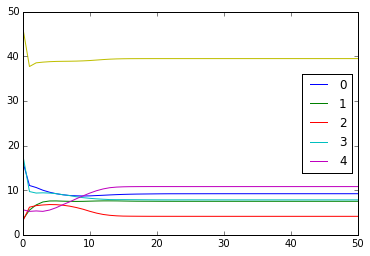

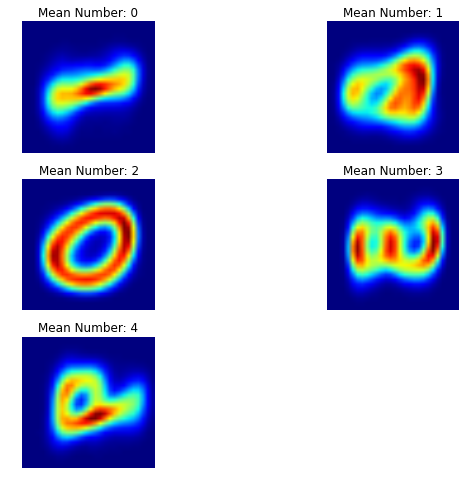

In [65]:
%autoreload
s = np.random.randint(0, 1000)
print(s)
k = 5
it = 50
km = KMeans(k, it, s).fit(images).plot_means()

509
Number in Mean Number 0 5222
Number in Mean Number 1 4002
Number in Mean Number 2 6065
Number in Mean Number 3 7970
Number in Mean Number 4 7155
Number in Mean Number 5 4549
Number in Mean Number 6 4354
Number in Mean Number 7 8417
Number in Mean Number 8 5544
Number in Mean Number 9 6722


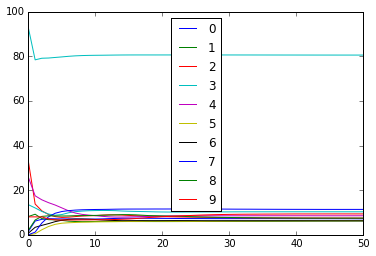

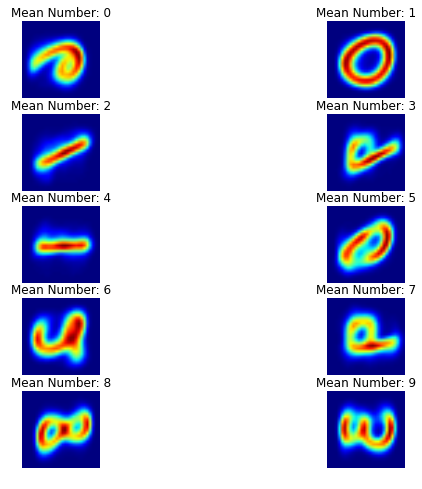

In [66]:
%autoreload
s = np.random.randint(0, 1000)
print(s)
k = 10
km = KMeans(k, it, s).fit(images).plot_means()

28
Number in Mean Number 0 2681
Number in Mean Number 1 2893
Number in Mean Number 2 3629
Number in Mean Number 3 3338
Number in Mean Number 4 3367
Number in Mean Number 5 2576
Number in Mean Number 6 3010
Number in Mean Number 7 3107
Number in Mean Number 8 3763
Number in Mean Number 9 2490
Number in Mean Number 10 2872
Number in Mean Number 11 1760
Number in Mean Number 12 2224
Number in Mean Number 13 2908
Number in Mean Number 14 2624
Number in Mean Number 15 3731
Number in Mean Number 16 3737
Number in Mean Number 17 4444
Number in Mean Number 18 2430
Number in Mean Number 19 2416


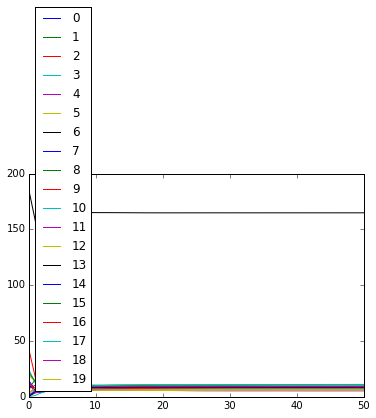

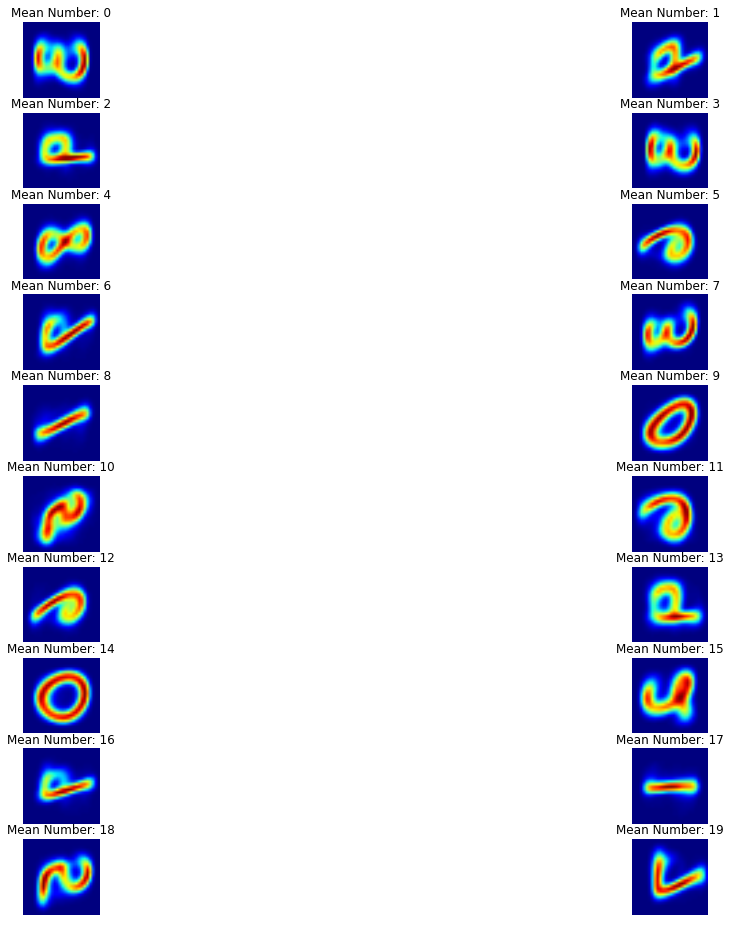

In [67]:
%autoreload
s = np.random.randint(0, 1000)
print(s)
k = 20
km = KMeans(k, it, s).fit(images).plot_means((20,16))

The loss definitely varies with the random initializations. We can see that it can sometimes get it right, while some shapes are just random masses. The more centers we have, the more we can see that we get specific letters. However there are still overlaps.

# Problem 2

In [68]:
train = scipy.io.loadmat("joke_data/joke_train.mat")['train']
validation = pd.read_csv("joke_data/validation.txt", header=None)
validation.columns = ['User_Index','Joke_Index', 'Truth']
query = pd.read_csv("joke_data/query.txt", header=None)
query.columns = ['KaggleId', 'User_Index', 'Joke_Index']

## 2.2

In [69]:
recs = pd.DataFrame(train).mean(axis=0).values
avg_preds = validation.Joke_Index.map(lambda x: 1 if recs[x - 1] > 0 else 0)
print("Accuracy via Averages:", sum(validation.Truth == avg_preds) / len(validation))

Accuracy via Averages: 0.620325203252


*knn version*

In [70]:
class KNN:
    def __init__(self, k):
        self.k = k
        self.X = None
        
    def fit(self, X):
        self.X = X
        return self
    
    def inner_predict(self, X):
        for chunk in np.vsplit(X, 43):
            preds = cdist(self.X, chunk, 'euclidean')
            for x_neighbors in preds.T.argsort(axis=1)[:,:self.k]:
                yield self.X[x_neighbors].mean(axis=0)

    def predict(self, X):
        temp = pd.DataFrame(self.inner_predict(X_train), columns=np.arange(1,101)) \
            .applymap(lambda x: 1 if x > 0 else 0)
        temp.index = temp.index + 1
        return temp

In [71]:
X_train = pd.DataFrame(train).fillna(0).values
k = 10
knn = KNN(k)
preds = knn.fit(X_train).predict(X_train)
scores = []
for ((user, joke), rating) in validation.groupby(['User_Index', 'Joke_Index']):
    truth = rating['Truth'].values[0]
    guess = preds.ix[user, joke]
    scores.append(truth == guess)
print("k=%i Accuracy: %.3f" % (k, sum(scores)/len(scores)))

k=10 Accuracy: 0.642


In [72]:
X_train = pd.DataFrame(train).fillna(0).values
k = 100
knn = KNN(k)
preds = knn.fit(X_train).predict(X_train)
scores = []
for ((user, joke), rating) in validation.groupby(['User_Index', 'Joke_Index']):
    truth = rating['Truth'].values[0]
    guess = preds.ix[user, joke]
    scores.append(truth == guess)
print("k=%i Accuracy: %.3f" % (k, sum(scores)/len(scores)))

k=100 Accuracy: 0.689


In [73]:
X_train = pd.DataFrame(train).fillna(0).values
k = 1000
knn = KNN(k)
preds = knn.fit(X_train).predict(X_train)
scores = []
for ((user, joke), rating) in validation.groupby(['User_Index', 'Joke_Index']):
    truth = rating['Truth'].values[0]
    guess = preds.ix[user, joke]
    scores.append(truth == guess)
print("k=%i Accuracy: %.3f" % (k, sum(scores)/len(scores)))

k=1000 Accuracy: 0.694


KNN definitely seems to have better results. They consistently have better accuracies.

## 2.3

### 2.3.1 & 2.3.2

In [74]:
import scipy as sp
import scipy.sparse.linalg
mse = lambda y, y_hat: (y_hat - y) ** 2

In [75]:
X_train = pd.DataFrame(train).fillna(0).values

In [76]:
class LFM:
    def __init__(self, k):
        self.u = None
        self.s = None
        self.v = None
        self.k = k
    def fit(self, X):
        u, s, v = sp.sparse.linalg.svds(X, k=self.k)
        self.u = u
        self.s = s
        self.v = v
        temp = pd.DataFrame((self.u * self.s).dot(self.v), columns=np.arange(1,101)) \
                    .applymap(lambda x: 1 if x > 0 else 0)
        temp.index = temp.index + 1
        self.rebuilt = temp
        return self
    def evaluate(self, validation):
        y = []
        y_hat = []
        for ((user, joke), rating) in validation.groupby(['User_Index', 'Joke_Index']):
            truth = rating['Truth'].values[0]
            guess = self.rebuilt.ix[user, joke]
            y.append(truth)
            y_hat.append(guess)
            
        y = pd.Series(y)
        y_hat = pd.Series(y_hat)
        
        error = mse(y, y_hat).sum()
        scores = y == y_hat
        print("k=%i Accuracy: %.3f" % (self.k, sum(scores)/len(scores)))
        return(self.k, sum(scores)/len(scores), error)
    def predict(self, query):
        y_hat = []
        for ((user, joke), identifier) in query.groupby(['User_Index', 'Joke_Index']):
            guess = self.rebuilt.ix[user, joke]
            kId = identifier['KaggleId'].values[0]
            y_hat.append((kId, guess))
            
        y_hat = pd.DataFrame(y_hat)
        y_hat.columns = ["Id", "Category"]
        return y_hat

In [77]:
all_k = []

In [78]:
k=2
lfm = LFM(k=k)
all_k.append(lfm.fit(X_train).evaluate(validation))

k=2 Accuracy: 0.705


In [79]:
k=5
lfm = LFM(k=k)
all_k.append(lfm.fit(X_train).evaluate(validation))

k=5 Accuracy: 0.715


In [80]:
k=10
lfm = LFM(k=k)
all_k.append(lfm.fit(X_train).evaluate(validation))

k=10 Accuracy: 0.717


In [81]:
k=20
lfm = LFM(k=k)
all_k.append(lfm.fit(X_train).evaluate(validation))

k=20 Accuracy: 0.686


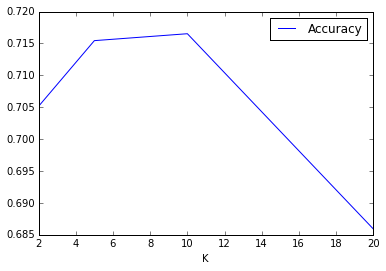

In [82]:
pd.DataFrame(all_k, columns=['K', 'Accuracy', 'MSE']).plot(x='K', y='Accuracy')

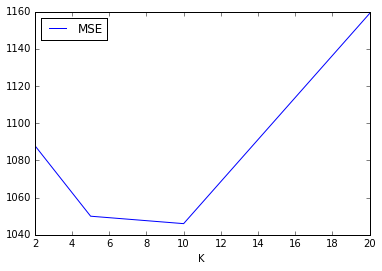

In [83]:
pd.DataFrame(all_k, columns=['K', 'Accuracy', 'MSE']).plot(x='K', y='MSE')

### 2.3.3

In [84]:
regualarized_mse = lambda U, V, truth, weights: np.sum((weights * (truth - U.dot(V))**2))

In [85]:
X_train.shape

(24983, 100)

In [87]:
class RegularizedLFM:
    def __init__(self, k, lamb, n_iters):
        self.U = None
        self.V = None
        self.k = k
        self.n_iters = n_iters
        self.lamb = lamb
        self.errors = []
        
    def fit(self, X_):
        W = pd.DataFrame(X_).notnull().astype(np.float64).values
        X_ = pd.DataFrame(X_).fillna(0).values
        
        U = np.random.normal(size=(len(X_), self.k))
        V = np.random.normal(size=(self.k, len(X_[0])))
        
        for _ in range(self.n_iters):
            U = np.linalg.solve(V.dot(V.T) + self.lamb * np.eye(self.k), V.dot(X_.T)).T
            V = np.linalg.solve(U.T.dot(U) + self.lamb * np.eye(self.k), U.T.dot(X_))
            self.errors.append((_, regualarized_mse(U, V, X_, W)))
            
        self.U = U
        self.V = V
        self.rebuilt = pd.DataFrame(U.dot(V), columns=np.arange(1,101)) \
                            .applymap(lambda x: 1 if x > 0 else 0)
        self.rebuilt.index = self.rebuilt.index + 1
        assert self.rebuilt.shape == X_.shape
        return self
        
    def evaluate(self, validation):
        y = []
        y_hat = []
        for ((user, joke), rating) in validation.groupby(['User_Index', 'Joke_Index']):
            truth = rating['Truth'].values[0]
            guess = self.rebuilt.ix[user, joke]
            y.append(truth)
            y_hat.append(guess)
            
        y = pd.Series(y)
        y_hat = pd.Series(y_hat)
        
        error = mse(y, y_hat).sum()
        scores = y == y_hat
        print("k=%i Accuracy: %.3f" % (self.k, sum(scores)/len(scores)))
        return(self.k, sum(scores)/len(scores), error)
    def predict(self, query):
        y_hat = []
        for ((user, joke), identifier) in query.groupby(['User_Index', 'Joke_Index']):
            guess = self.rebuilt.ix[user, joke]
            kId = identifier['KaggleId'].values[0]
            y_hat.append((kId, guess))
            
        y_hat = pd.DataFrame(y_hat)
        y_hat.columns = ["Id", "Category"]
        return y_hat

In [88]:
all_k = []

In [89]:
k=2
rlfm = RegularizedLFM(k, 1e-3, 15)
all_k.append(rlfm.fit(X_train).evaluate(validation))

k=2 Accuracy: 0.705


In [90]:
k=5
rlfm = RegularizedLFM(k, 1e-3, 15)
all_k.append(rlfm.fit(X_train).evaluate(validation))

k=5 Accuracy: 0.712


In [91]:
k=10
rlfm = RegularizedLFM(k, 1e-3, 15)
all_k.append(rlfm.fit(X_train).evaluate(validation))

k=10 Accuracy: 0.713


In [92]:
k=20
rlfm = RegularizedLFM(k, 1e-6, 15)
all_k.append(rlfm.fit(X_train).evaluate(validation))

k=20 Accuracy: 0.686


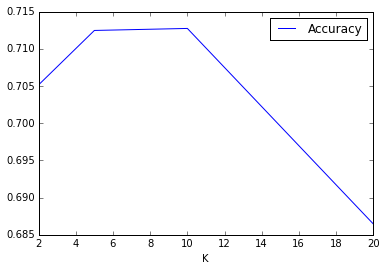

In [93]:
pd.DataFrame(all_k, columns=['K', 'Accuracy', 'MSE']).plot(x='K', y='Accuracy')

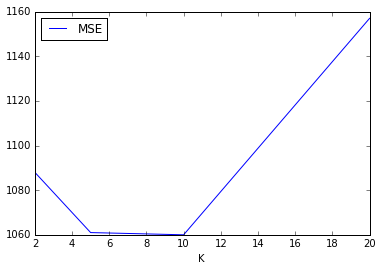

In [94]:
pd.DataFrame(all_k, columns=['K', 'Accuracy', 'MSE']).plot(x='K', y='MSE')

### 2.4.1


In [95]:
k=10
rlfm = RegularizedLFM(k, 1e-6, 15)
all_k.append(rlfm.fit(X_train).evaluate(validation))

k=10 Accuracy: 0.714


In [96]:
preds = rlfm.predict(query)
preds.to_csv("predictions.csv", index=False)

Kaggle Score: 0.6864

# 3

In [97]:
import scipy.misc
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import scipy.io

In [98]:
celebs = !ls eigenfaces_data/CelebrityDatabase/
students = !ls eigenfaces_data/StudentDatabase/
mask = sp.io.loadmat("eigenfaces_data/mask.mat")['mask']
unmasked_pixels = np.where(mask)

celebs = np.array([sp.misc.imread("eigenfaces_data/CelebrityDatabase/" + x)\
          .astype(np.uint8)[unmasked_pixels] for x in celebs], dtype=np.uint8)
students = np.array([sp.misc.imread("eigenfaces_data/StudentDatabase/" + x)\
            .astype(np.uint8)[unmasked_pixels] for x in students], dtype=np.uint8)

In [99]:
def img_to_uint8(f_img): ## Borrowed from Piazza: https://piazza.com/class/idkq8912ql86mq?cid=504
        """Convert float image to type uint8"""
        t = np.clip(f_img, 0, 255)
        return t.astype(np.uint8)
    
def show_image(im):
    full_im = np.zeros(np.shape(mask), dtype=np.uint8)
    full_im[unmasked_pixels] = img_to_uint8(im)
    plt.imshow(full_im)

In [100]:
def plot_eig_face(celebs, celeb_num):
    mean = np.sum(celebs, 0)/float(len(celebs))
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,3,1)
    a.set_title("Original")
    show_image(celebs[celeb_num])
    b=fig.add_subplot(1,3,2)
    b.set_title("10 Eigenvalues")
    U, S, V = sp.sparse.linalg.svds(celebs.astype(float) - mean, k=10)
    show_image(U[celeb_num].dot(np.diag(S).dot(V)) + mean)
    c=fig.add_subplot(1,3,3)
    c.set_title("Error")
    k10_error = ((celebs[celeb_num] - U[celeb_num].dot(np.diag(S).dot(V))) ** 2).sum()
    U, S, V = sp.sparse.linalg.svds(celebs.astype(float) - mean, k=50)
    k50_error = ((celebs[celeb_num] - U[celeb_num].dot(np.diag(S).dot(V))) ** 2).sum()
    U, S, V = sp.sparse.linalg.svds(celebs.astype(float) - mean, k=100)
    k100_error = ((celebs[celeb_num] - U[celeb_num].dot(np.diag(S).dot(V))) ** 2).sum()
    pd.Series([k10_error, k50_error, k100_error]).plot()

In [101]:
def plot_eig_features(celebs, num_eigenfaces):

    U, S, V = sp.linalg.svd(celebs.astype(float) - mean, full_matrices=False)
    for val in range(num_eigenfaces):
        fig = plt.figure(figsize=(5, 5))
        eig_face = np.diag(S).dot(V)[val+1]
        ax=fig.add_subplot(1,1, 1)
        ax.set_title("%i Eigenvalues" % val)
        show_image(eig_face + mean)

## 3.1

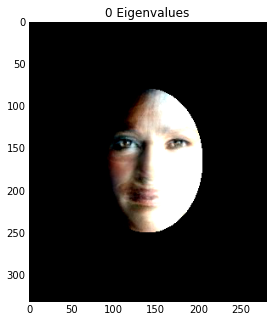

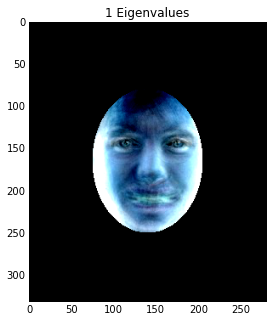

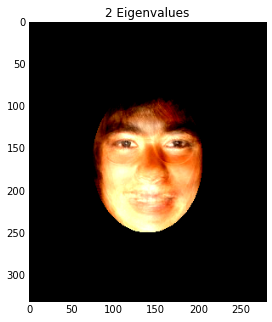

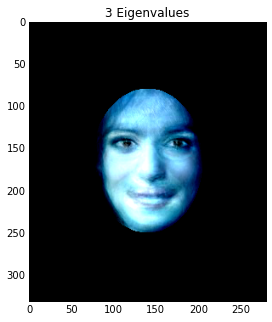

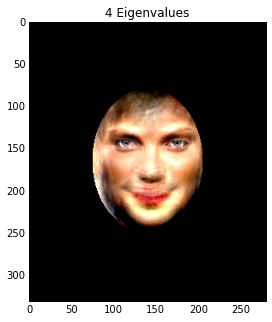

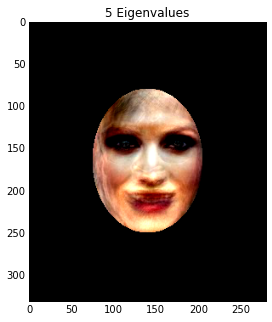

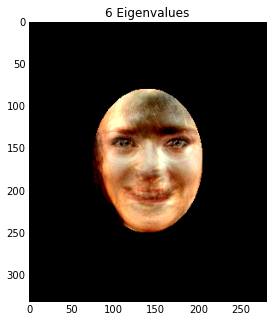

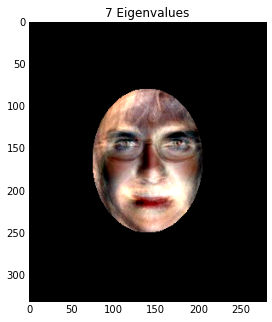

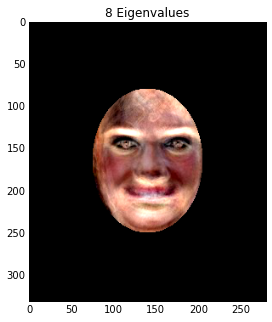

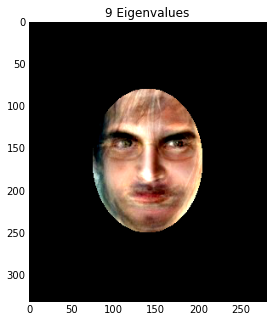

In [102]:
plot_eig_features(celebs, 10)

We can see that the core variations are around the mouth. There's a lot of variance around there so it's harder to reconstruct correctly. However the eyes are fairly stable and show up approximately the same (although their direction does vary). There's also a fair amount of variation around the lighting as the other eigenfaces show us.

## 3.2

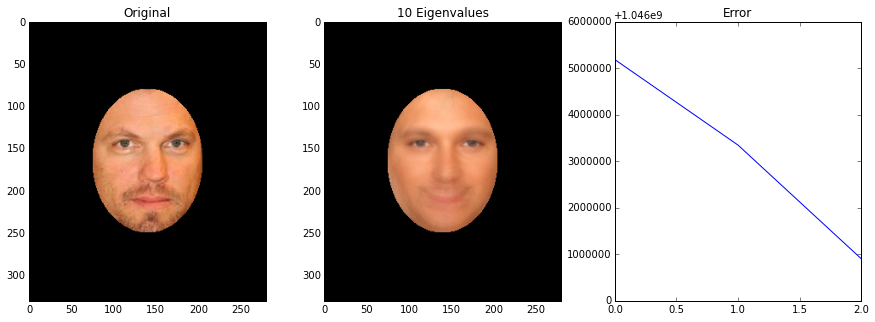

In [103]:
plot_eig_face(celebs, 0)

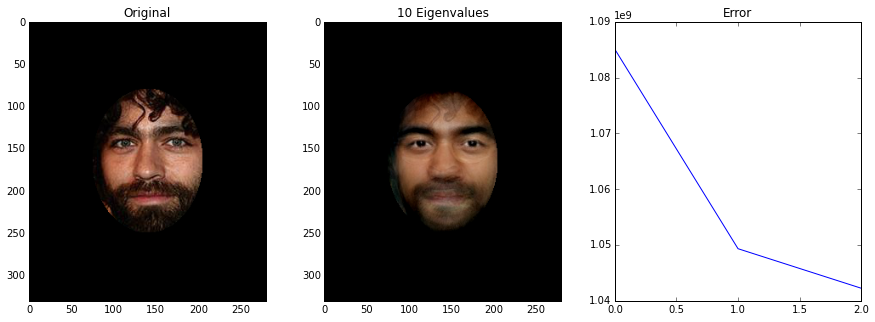

In [104]:
plot_eig_face(celebs, 1)

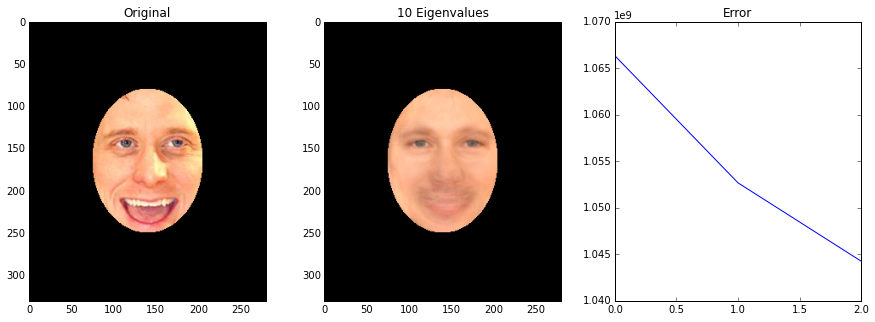

In [105]:
plot_eig_face(celebs, 2)

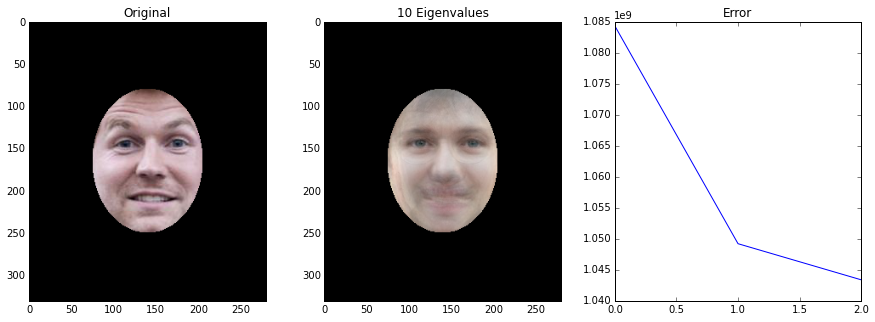

In [106]:
plot_eig_face(celebs, 3)

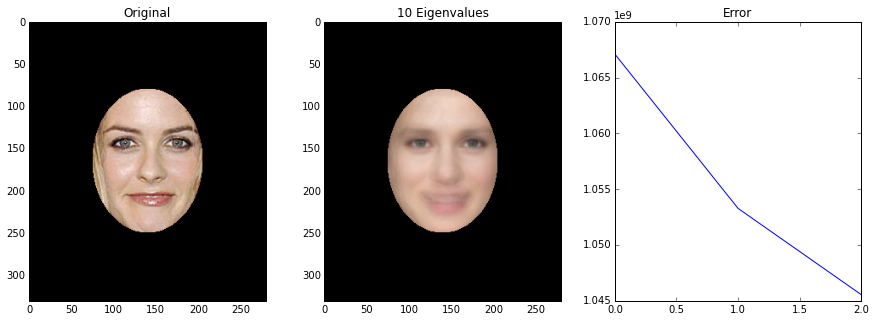

In [107]:
plot_eig_face(celebs, 4)

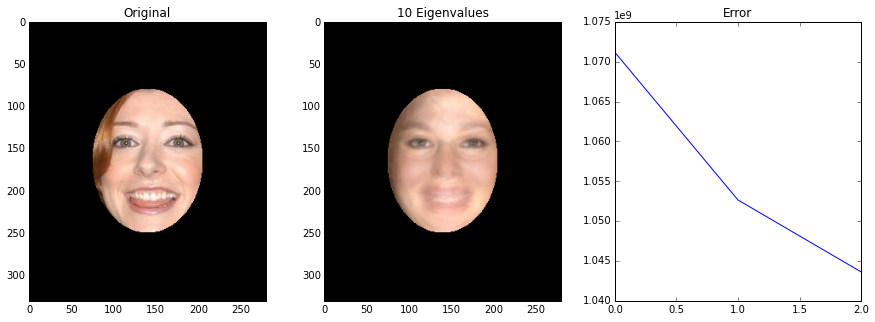

In [108]:
plot_eig_face(celebs, 5)

In [109]:
def plot_eig_face(celebs, students, celeb_num):
    mean = np.sum(celebs, 0)/float(len(celebs))
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,3,1)
    a.set_title("Original")
    show_image(students[celeb_num])
    
    b=fig.add_subplot(1,3,2)
    b.set_title("10 Eigenvalues")
    U, S, V = sp.sparse.linalg.svds(celebs.astype(float) - mean, k=10)
    U1, S1, V1 = sp.sparse.linalg.svds(students.astype(float) - mean, k=10)
    show_image(U1[celeb_num].dot(np.diag(S).dot(V)) + mean)
    c=fig.add_subplot(1,3,3)
    c.set_title("Error")
    k10_error = ((students[celeb_num] - U1[celeb_num].dot(np.diag(S).dot(V))) ** 2).sum()
    
    U, S, V = sp.sparse.linalg.svds(celebs.astype(float) - mean, k=11)
    U1, S1, V1 = sp.sparse.linalg.svds(students.astype(float) - mean, k=11)
    k50_error = ((students[celeb_num] - U1[celeb_num].dot(np.diag(S).dot(V))) ** 2).sum()
    
    U, S, V = sp.sparse.linalg.svds(celebs.astype(float) - mean, k=12)
    U1, S1, V1 = sp.sparse.linalg.svds(students.astype(float) - mean, k=12)
    k100_error = ((students[celeb_num] - U1[celeb_num].dot(np.diag(S).dot(V))) ** 2).sum()
    
    pd.Series([k10_error, k50_error, k100_error]).plot()

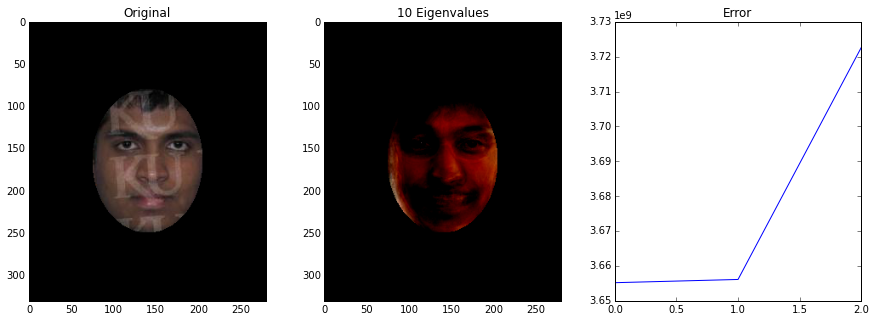

In [110]:
plot_eig_face(celebs, students, 0)

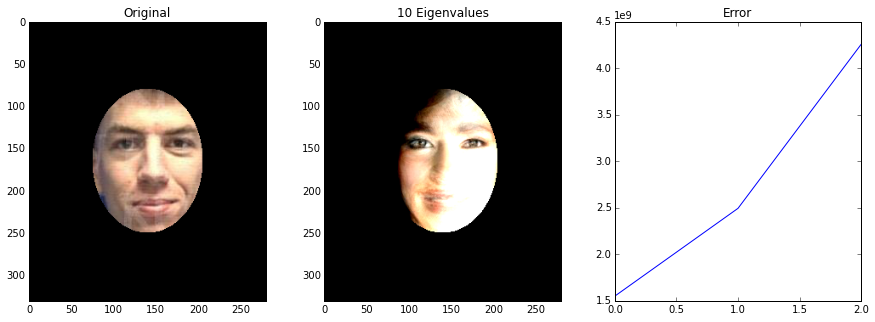

In [111]:
plot_eig_face(celebs, students, 1)

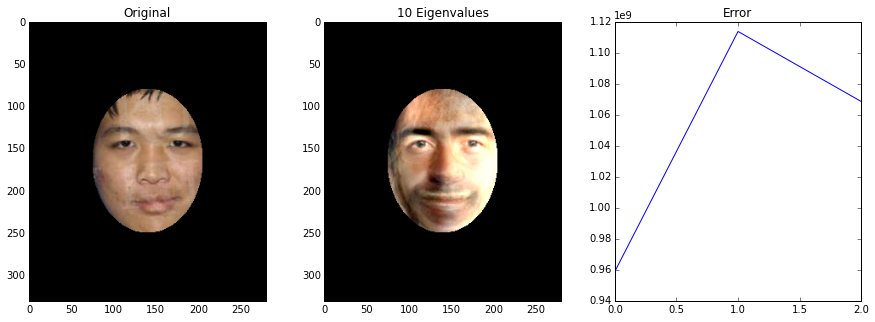

In [112]:
plot_eig_face(celebs, students, 2)

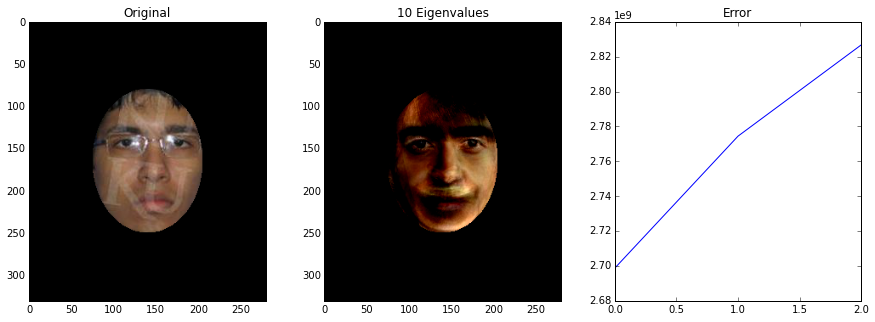

In [113]:
plot_eig_face(celebs, students, 3)

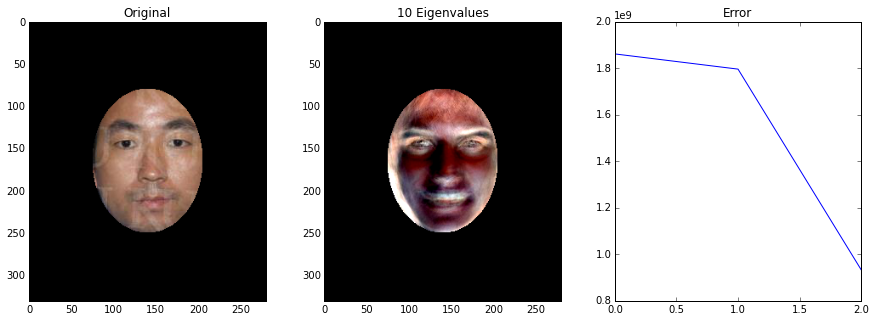

In [114]:
plot_eig_face(celebs, students, 4)

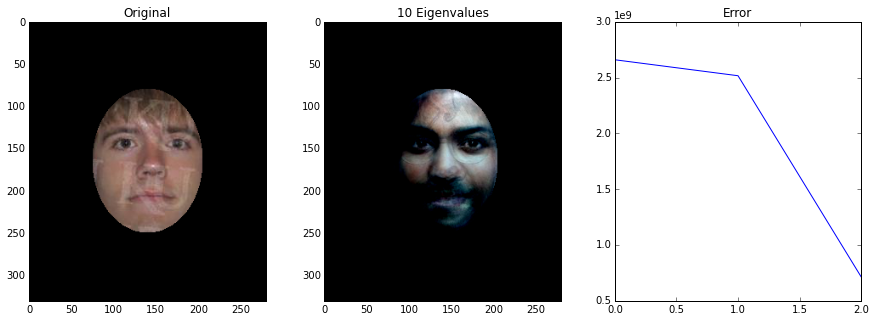

In [115]:
plot_eig_face(celebs, students, 5)